This notebook reproduces the tables and figures describing our empirical results on the OpTC and LANL datasets.

In [1]:
import gzip
import json
import os

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from joblib import Parallel, delayed

from matplotlib.ticker import AutoMinorLocator, MultipleLocator

from sklearn.metrics import roc_auc_score, average_precision_score

First of all, we define some helper functions to read results from files and make figures.

In [2]:
def read_res_file(file_path, unique_malicious=False, data_dir=None, train_cutoff=0):
    with gzip.open(file_path, 'rt') as f:
        dat = json.loads(f.read())
    if unique_malicious:
        # Get the names of the files containing the edge list for each window in the test set
        ids = sorted([int(fname.split('.')[0]) for fname in os.listdir(data_dir)])
        ids = [i for i in ids if i >= train_cutoff]
        mal_edges = defaultdict(list)
        for i, ts in enumerate(ids):
            # For each window, we collect the row indices corresponding to lateral movement edges
            # to build the mal_edges map.
            # This map lists all occurrences of each lateral movement edge, i.e.,
            # edge -> [(window_index1, row_index1), (window_index2, row_index2), ...]
            fname = f'{ts}.csv'
            df = pd.read_csv(os.path.join(data_dir, fname))
            scored = df[df['auxiliary'] == 0].reset_index()
            sub = scored[scored['label'] == 1]
            if len(sub) == 0:
                continue
            for idx, src, rel, dst in zip(sub.index, sub['src'], sub['rel'], sub['dst']):
                mal_edges[(src, rel, dst)].append((i, idx))
        # We now list the edges that should be deleted, i.e., lateral movement edges for which
        # the same (src, rel, dst) triple occurs with a higher anomaly score
        exclude = defaultdict(set)
        for key in mal_edges:
            # For each (src, rel, dst) triple, we find the highest-scoring occurrence and
            # mark all other occurrences for deletion
            scores = [dat['scores'][i][j] for i, j in mal_edges[key]]
            idx = np.argmax(scores)
            for k, (i, j) in enumerate(mal_edges[key]):
                if k != idx:
                    exclude[i].add(j)
        # Finally, we delete the duplicate lateral movement edges
        dat['labels'] = [
            [l for j, l in enumerate(lab) if i not in exclude or j not in exclude[i]]
            for i, lab in enumerate(dat['labels'])
        ]
        dat['scores'] = [
            [s for j, s in enumerate(sco) if i not in exclude or j not in exclude[i]]
            for i, sco in enumerate(dat['scores'])
        ]
    y_true = np.concatenate(dat['labels'])
    y_pred = np.concatenate(dat['scores'])
    res = [
        roc_auc_score(y_true, y_pred),
        average_precision_score(y_true, y_pred),
        dat['labels'],
        dat['scores']
    ]
    if 'times' in dat:
        res.append(dat['times'])
    return res

def read_data(base_dir, names=None, unique_malicious=False, data_dir=None, train_cutoff=0):
    # Wrapper function that parallelizes file reads
    fnames = os.listdir(base_dir)
    files = [os.path.join(base_dir, fname) for fname in fnames]
    if names is None:
        names = dict(zip(fnames, [fname.split('.')[0] for fname in fnames]))
    results = dict(zip(
        [names[fname] for fname in fnames],
        Parallel(n_jobs=-1)(
            delayed(read_res_file)(fp, unique_malicious, data_dir, train_cutoff)
            for fp in files
        )
    ))
    return results

In [3]:
def compute_recall_at_budgets(results, budgets):
    names = sorted(results.keys())
    res = {}
    for name in names:
        labels, scores = [
            [np.array(x) for x in arr]
            for arr in results[name][2:4]
        ]
        detect_counts = np.array([
            sum(lab[np.argsort(-ys)[:b]].sum() for lab, ys in zip(labels, scores))
            for b in budgets
        ]).astype(float)
        detect_counts /= sum(lab.sum() for lab in labels)
        res[name] = detect_counts
    return res

In [4]:
def make_quantile_name(q):
    if float(int(q * 100)) / 100 == q:
        qname = str(int(q * 100))
    else:
        qname = f'{100 * q}'
    return '$Q_{' + qname + '}$'

def plot_scores_over_time(results):
    names = sorted(results.keys())
    fig, axes = plt.subplots(len(results), 1)
    for row, name in enumerate(names):
        ax = axes[row]
        xs = np.arange(len(results[name][3])) # Window indices
        labels, scores = results[name][2:4]
        quantiles = [
            (make_quantile_name(q),
             [np.quantile(ys, q) if len(ys) > 0 else 0 for ys in scores])
            for q in (.9, .99, .999)
        ]
        colors = ['black', 'gray', 'lightgray']
        lines = []
        line_labels = []
        for (qname, values), color in zip(quantiles, colors):
            # For each percentile, we plot its value over time and color below the curve
            lines.append(ax.plot(
                xs, values,
                color=color, alpha=.8
            )[0])
            ax.fill_between(
                xs, values,
                color=color, alpha=.4
            )
            line_labels.append(qname)
        # Add points representing lateral movement edges
        rt_windows = [win for win, lab in enumerate(results[name][2]) for l in lab if l == 1]
        rt_scores = [y for win, (lab, ys) in enumerate(zip(labels, scores)) for y, l in zip(ys, lab) if l == 1]
        lines.append(ax.scatter(
            np.array(rt_windows) + .5 * np.random.rand(len(rt_windows)), rt_scores,
            color='red', s=5
        ))
        line_labels.append('Lateral movement')
        ax.set_ylabel('Scores')
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        if row < len(names) - 1:
            ax.set_xticks([])
        else:
            ax.set_xlabel('Time window')
        ax.grid(axis='y', which='both', alpha=.3)
        ax.set_title(name, loc='right', pad=0)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    fig.legend(lines, line_labels, ncol=4, loc='outside upper center')
    plt.subplots_adjust(hspace=.24, top=.92)
    fig.set_size_inches(9, 1.9 * len(names))

In [5]:
def plot_times(times):
    left = 0
    colors = ['#555555', '#888888', '#cccccc']
    for i, k in enumerate(['retrieval', 'scoring', 'refinement']):
        a = np.array(times[k])
        plt.barh(
            0, a.mean(),
            height=.2, left=left,
            xerr=a.std(),
            label=k[0].upper() + k[1:],
            error_kw={'alpha': .4}, color=colors[i]
        )
        left += a.mean()
    plt.yticks([])
    plt.ylim(-.2, .5)
    plt.xlabel('Time (s)')
    plt.legend(loc='upper center', ncol=2)
    plt.gcf().set_size_inches(3.5, 2.1)
    plt.subplots_adjust(bottom=.3)
    for key in ('top', 'right', 'left'):
        plt.gca().spines[key].set_visible(False)

In [6]:
def print_res_table(results):
    names = sorted(results.keys())
    rec_at_b = compute_recall_at_budgets(results, [3, 5, 10])
    df = pd.DataFrame({
        'Algorithm': names,
        'AUC': [results[name][0] for name in names],
        'AP': [results[name][1] for name in names],
        'Rec@3': [rec_at_b[name][0] for name in names],
        'Rec@5': [rec_at_b[name][1] for name in names],
        'Rec@10': [rec_at_b[name][2] for name in names]
    })
    print(df.to_string(float_format='%.4f', index=False))

In [7]:
NAMES = { # Maps file names to algorithm names
    'res_argus.json.gz': 'Argus',
    'res_-1.json.gz': 'UltraLMD',
    'res_-1_refine.json.gz': 'UltraLMD + refinement',
    'res_10.json.gz': 'UltraLMD + retrieval',
    'res_100.json.gz': 'UltraLMD + retrieval',
    'res_10_refine.json.gz': 'UltraLMD++',
    'res_100_refine.json.gz': 'UltraLMD++'
}

### OpTC dataset

In [8]:
base_dir = os.path.join('results', 'optc')
res_optc = read_data(base_dir, names=NAMES)

Performance metrics (Table 2 in the paper):

In [9]:
print_res_table(res_optc)

            Algorithm    AUC     AP  Rec@3  Rec@5  Rec@10
                Argus 0.9300 0.0240 0.0064 0.0113  0.0273
             UltraLMD 0.9826 0.1003 0.0208 0.0319  0.0559
UltraLMD + refinement 0.9826 0.1003 0.0192 0.0319  0.0559
 UltraLMD + retrieval 0.9909 0.1506 0.0256 0.0367  0.0607
           UltraLMD++ 0.9909 0.1510 0.0256 0.0383  0.0623


Temporal dynamics of the anomaly score distribution for Argus and UltraLMD++ (Figure 3):

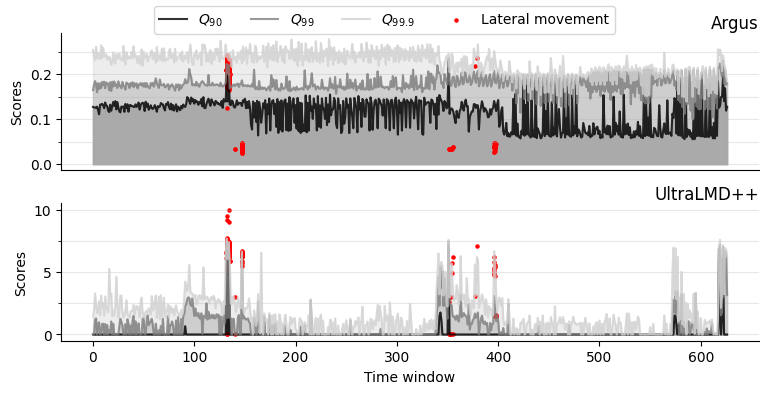

In [10]:
sub_res = {k: res_optc[k] for k in ('Argus', 'UltraLMD++')}
plot_scores_over_time(sub_res)

Run time of UltraLMD++ (Figure 4):

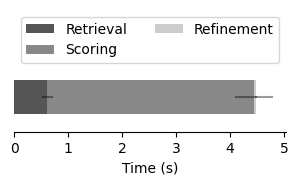

In [11]:
plot_times(res_optc['UltraLMD++'][4])

### LANL dataset

In [12]:
base_dir = os.path.join('results', 'lanl')
res_lanl = read_data(base_dir, names=NAMES)

We also load the results without duplicate lateral movement edges:

In [13]:
data_dir = os.path.join('datasets', 'lanl', 'edges')
res_lanl_deduplicated = read_data(
    base_dir, names=NAMES,
    unique_malicious=True, data_dir=data_dir, train_cutoff=41
)

Performance metrics (Table 3 in the paper):

In [14]:
print_res_table(res_lanl)

            Algorithm    AUC     AP  Rec@3  Rec@5  Rec@10
                Argus 0.9749 0.0065 0.0100 0.0260  0.0900
             UltraLMD 0.7645 0.0020 0.0260 0.0400  0.0720
UltraLMD + refinement 0.7606 0.0026 0.0360 0.0460  0.0820
 UltraLMD + retrieval 0.8969 0.0040 0.0300 0.0480  0.0860
           UltraLMD++ 0.8938 0.0056 0.0340 0.0560  0.1040


Without duplicates (bottom rows of Table 3):

In [15]:
print_res_table(res_lanl_deduplicated)

            Algorithm    AUC     AP  Rec@3  Rec@5  Rec@10
                Argus 0.9821 0.0056 0.0166 0.0364  0.1126
             UltraLMD 0.9394 0.0034 0.0430 0.0662  0.1192
UltraLMD + refinement 0.9328 0.0042 0.0596 0.0762  0.1358
 UltraLMD + retrieval 0.9920 0.0063 0.0497 0.0795  0.1424
           UltraLMD++ 0.9868 0.0088 0.0629 0.0927  0.1788


Temporal dynamics of the anomaly score distribution for Argus and UltraLMD++ (Figure 5):

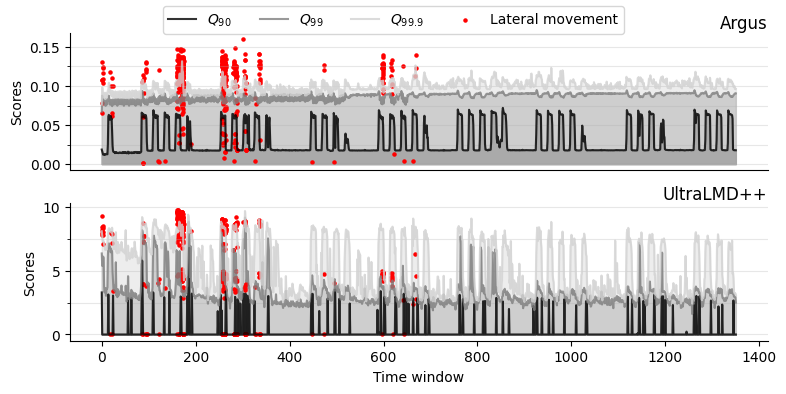

In [16]:
sub_res = {k: res_lanl[k] for k in ('Argus', 'UltraLMD++')}
plot_scores_over_time(sub_res)

Run time of UltraLMD++ (Figure 6):

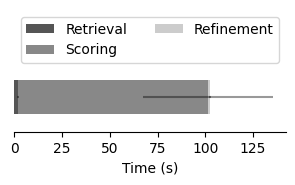

In [17]:
plot_times(res_lanl['UltraLMD++'][4])